In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch import nn
from torch.utils.data import DataLoader

from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.numerical import build_gaussian_heatmap
from torchlake.pose_estimation.controller.hourglass.trainer import \
    StackedHourglassTrainer
from torchlake.pose_estimation.datasets.mpii import (MPII_CLASS_NAMES,
                                                     MPII_JOINT_EDGES,
                                                     MPIIFromJSON,
                                                     MPIIFromLMDB, MPIIFromRaw)
from torchlake.pose_estimation.models.hourglass import StackedHourglass
from torchlake.pose_estimation.utils.plot import draw_skeleton

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
torch.__version__

'2.6.0+cu126'

# setting

In [4]:
artifact_path = Path('../../artifacts/hourglass')
artifact_path.mkdir(exist_ok=True)

In [5]:
data_path = Path("../../data/MPII")

In [6]:
DEVICE = torch.device("cuda:0")

# data

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 256

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        # A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=0.25, rotate_limit=0.3),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(
        format="xy",
        remove_invisible=False,
    ),
)

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [10]:
# train_dataset = MPIIFromRaw(
#     data_path,
#     mode="train",
#     crop_by_person=True,
#     transform=transform,
# )

In [11]:
# to get json version
# train_dataset.to_json(data_path.joinpath("annotations.train.json"))

In [12]:
# train_dataset = MPIIFromJSON(
#     data_path,
#     data_path.joinpath("annotations.train.json"),
#     transform=transform,
# )

In [13]:
train_dataset = MPIIFromLMDB(
    "F://data/MPII",
    transform=transform,
)

In [14]:
for i, (x, y) in enumerate(train_dataset):
    print(i, x.shape, y.shape)
    break

0 torch.Size([3, 256, 256]) torch.Size([16, 3])


In [15]:
NUM_CLASS = len(MPII_CLASS_NAMES)

In [16]:
NUM_CLASS

16

In [17]:
# def collate_fn(batch) -> list[torch.Tensor]:
#     imgs, labels = [], []
#     for img, label in batch:
#         imgs.append(img)
#         labels.append(label)
    
#     return torch.cat(imgs), torch.cat(labels)

In [18]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    # for raw, json version use this line
    # lmdb doesn't need
    # collate_fn=collate_fn if train_dataset.crop_by_person else None, 
)

In [19]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 256, 256]) torch.Size([32, 16, 3])


# debug

In [20]:
# from torchlake.pose_estimation.utils.plot import draw_skeleton
# from torchlake.pose_estimation.datasets.mpii.constants import (
#     MPII_CLASS_NAMES,
#     MPII_JOINT_EDGES,
# )
# from torchlake.common.utils.convert import img_tensor_to_np

# img, label = train_dataset[12981]

# print("num person:", len(img))
# person_idx = 0
# copy_img = img_tensor_to_np(img[person_idx])

# person_label = label[person_idx]
# # rect = person_label[person_label[:, 2] == 0][:, :2].int()
# # x1, y1 = rect.min(0).values
# # x2, y2 = rect.max(0).values

# draw_skeleton(
#     copy_img,
#     label[person_idx, :, :2].unsqueeze(0),
#     masks=label[person_idx, :, 2:3].unsqueeze(0),
#     class_names=MPII_CLASS_NAMES,
#     class_edges=MPII_JOINT_EDGES,
#     radius=5,
# )

# plt.figure(figsize=(6, 6))
# plt.imshow(copy_img.clip(0, 1))
# # plt.imshow(copy_img[y1 - 15 : y2 + 15, x1 - 15 : x2 + 15])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


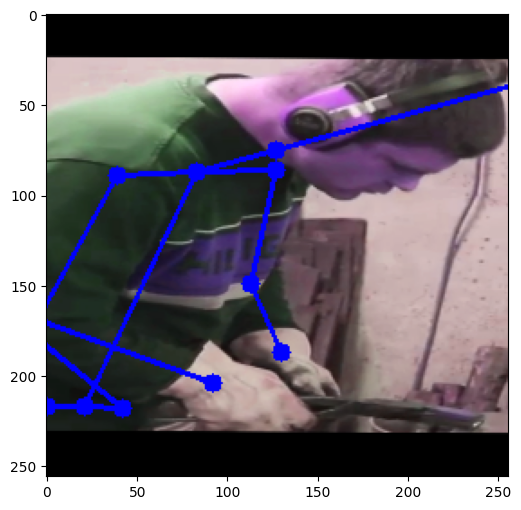

In [21]:
BATCH_IDX = 5
copy_img = img_tensor_to_np(x[BATCH_IDX])
draw_skeleton(
    copy_img,
    y[BATCH_IDX, None, :, :2],
    # y[BATCH_IDX, None, :, 2:3],
    class_names=MPII_CLASS_NAMES,
    class_edges=MPII_JOINT_EDGES,
    radius=5,
)
plt.figure(figsize=(6, 6))
plt.imshow(copy_img)

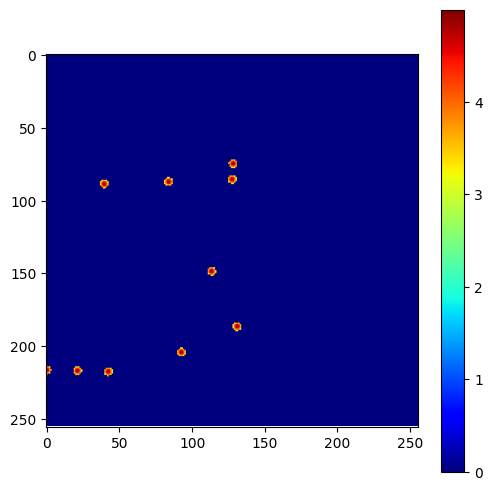

In [22]:
hm = build_gaussian_heatmap(
    y[BATCH_IDX, None, :, :2].flip(-1),
    copy_img.shape[:2],
    sigma=3,
    effective_range=3,
    normalized=False,
    amplitude=5,
).exp()[0]

plt.figure(figsize=(6, 6))
plt.imshow(hm.sum(0).unsqueeze(-1), cmap="jet")
plt.colorbar()

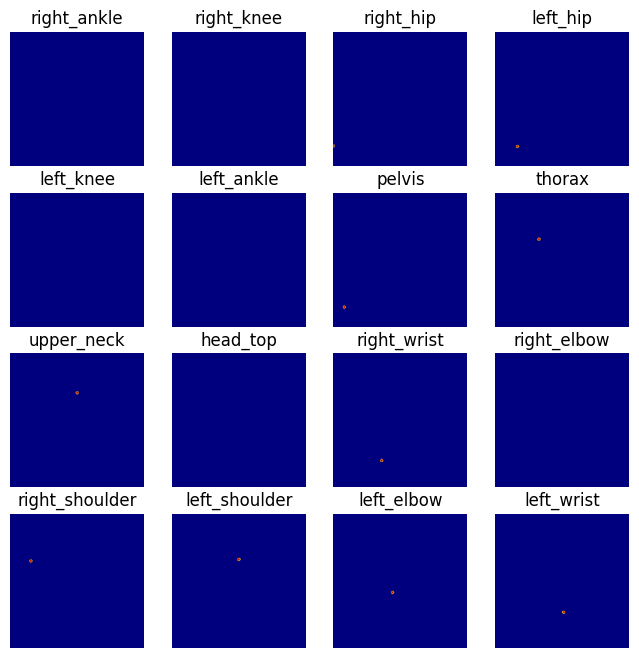

In [23]:
from torchlake.common.utils.plot import plot_grids

plot_grids(
    hm.unsqueeze(-1),
    titles=MPII_CLASS_NAMES,
    num_row=4,
    num_col=4,
    cmap="jet",
)

# model

In [20]:
model = StackedHourglass(output_size=NUM_CLASS, num_stack=4, num_nested=2).to(DEVICE)

In [25]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                 Param #
StackedHourglass                                                       --
├─Sequential: 1-1                                                      --
│    └─Conv2dNormActivation: 2-1                                       --
│    │    └─Conv2d: 3-1                                                9,408
│    │    └─BatchNorm2d: 3-2                                           128
│    │    └─ReLU: 3-3                                                  --
│    └─ResBlock: 2-2                                                   --
│    │    └─ReLU: 3-4                                                  --
│    │    └─BottleNeck: 3-5                                            49,536
│    │    └─Sequential: 3-6                                            8,448
│    └─MaxPool2d: 2-3                                                  --
│    └─ResBlock: 2-4                                                   --
│    │    └─ReLU: 3-7 

# train

In [21]:
SIGMA = 3
EFFECTIVE_RANGE = 3
AMPLITUDE = 5

In [22]:
EPOCH = 30

In [28]:
recorder = TrainRecorder(total_epoch=EPOCH)
recorder.increment_data_size(len(train_dataset))

In [29]:
trainer = StackedHourglassTrainer(sigma=SIGMA, effective_range=EFFECTIVE_RANGE, amplitude=AMPLITUDE, device=DEVICE)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss(reduction="sum")

In [31]:
scaler = torch.amp.GradScaler()

In [32]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [33]:
_ = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    scaler=scaler,
    recorder=recorder,
)

Enable AMP: True
Training...


100%|██████████| 892/892 [07:04<00:00,  2.10it/s]


------------------------------------
Epoch 1
------------------------------------
69525.17157411946 (0%)


100%|██████████| 892/892 [07:12<00:00,  2.06it/s]


------------------------------------
Epoch 2
------------------------------------
25066.93285878092 (-64%)


100%|██████████| 892/892 [07:11<00:00,  2.07it/s]


------------------------------------
Epoch 3
------------------------------------
24515.035223811337 (-2%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 4
------------------------------------
23942.492894842766 (-2%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 5
------------------------------------
23319.50579441218 (-3%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 6
------------------------------------
22671.230546705392 (-3%)


100%|██████████| 892/892 [06:58<00:00,  2.13it/s]


------------------------------------
Epoch 7
------------------------------------
22063.88028674461 (-3%)


100%|██████████| 892/892 [07:00<00:00,  2.12it/s]


------------------------------------
Epoch 8
------------------------------------
21491.30347796023 (-3%)


100%|██████████| 892/892 [06:59<00:00,  2.12it/s]


------------------------------------
Epoch 9
------------------------------------
20980.372385074563 (-2%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 10
------------------------------------
20507.281081506888 (-2%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 11
------------------------------------
20132.49413118829 (-2%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 12
------------------------------------
19755.252905958972 (-2%)


100%|██████████| 892/892 [06:58<00:00,  2.13it/s]


------------------------------------
Epoch 13
------------------------------------
19455.854914309217 (-2%)


100%|██████████| 892/892 [06:58<00:00,  2.13it/s]


------------------------------------
Epoch 14
------------------------------------
19166.92868365309 (-1%)


100%|██████████| 892/892 [06:58<00:00,  2.13it/s]


------------------------------------
Epoch 15
------------------------------------
18899.71910668021 (-1%)


100%|██████████| 892/892 [06:58<00:00,  2.13it/s]


------------------------------------
Epoch 16
------------------------------------
18649.35055537075 (-1%)


100%|██████████| 892/892 [07:00<00:00,  2.12it/s]


------------------------------------
Epoch 17
------------------------------------
18092.308702340513 (-3%)


100%|██████████| 892/892 [06:58<00:00,  2.13it/s]


------------------------------------
Epoch 18
------------------------------------
17929.640353660467 (-1%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 19
------------------------------------
17849.281438187092 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 20
------------------------------------
17793.81985133218 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 21
------------------------------------
17718.42721207372 (0%)


100%|██████████| 892/892 [06:58<00:00,  2.13it/s]


------------------------------------
Epoch 22
------------------------------------
17702.41971850712 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 23
------------------------------------
17702.329063747296 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 24
------------------------------------
17672.473163643997 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 25
------------------------------------
17671.99540582764 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 26
------------------------------------
17679.42343301415 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 27
------------------------------------
17670.688093008197 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 28
------------------------------------
17686.981286324488 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]


------------------------------------
Epoch 29
------------------------------------
17676.50036215077 (0%)


100%|██████████| 892/892 [06:59<00:00,  2.13it/s]

------------------------------------
Epoch 30
------------------------------------
17679.97997229709 (0%)


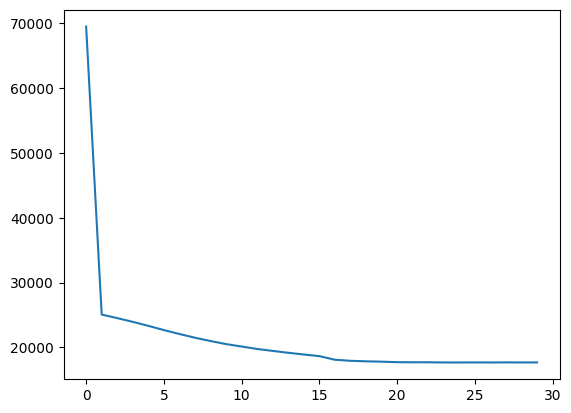

In [34]:
plt.plot(recorder.training_losses[0])

In [23]:
weight_manager = WeightManager(artifact_path.joinpath("hourglass.mpii.{num_stack}.{num_nested}.sigma.{sigma}.range.{range}.amplitude.{amplitude}.pth").as_posix())

In [24]:
model_path = weight_manager.get_filename(
    num_stack=model.num_stack,
    num_nested=model.num_nested,
    sigma=SIGMA,
    range=EFFECTIVE_RANGE,
    amplitude=AMPLITUDE,
)
model_path

WindowsPath('../../artifacts/hourglass/hourglass.mpii.4.2.sigma.3.range.3.amplitude.5.pth')

In [37]:
weight_manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\hourglass\hourglass.mpii.4.2.sigma.3.range.3.amplitude.5.pth, model size is 30.02MiB


In [25]:
weight_manager.load_weight(model_path, model)

# Inference

In [110]:
import numpy as np
from torchlake.common.utils.image import load_image
from torchlake.common.utils.plot import plot_grids
import torch.nn.functional as F

In [111]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [124]:
image = load_image("../../data/coco/val2017/000000009448.jpg", is_numpy=True)
image = load_image("../../data/coco/train2017/000000000436.jpg", is_numpy=True)
# image = load_image("../../data/coco/train2017/000000000474.jpg", is_numpy=True)


In [125]:
# x = train_dataset[100][0]
x = test_transform(image=image)["image"]

In [126]:
with torch.no_grad():
    pred = model(x[None, ...].to(DEVICE))[:, -1].detach().cpu()
    # pred = (model(x[None, ...].to(DEVICE))[:, -1] + model(x[None, ...].flip(-1).to(DEVICE))[:, -1].flip(-1)).div(2).detach().cpu()

In [127]:
# smooth heatmap
# from torch import nn
# pool = nn.MaxPool2d(3, 1, padding=1)
# from torchvision.transforms import GaussianBlur
# pool = GaussianBlur(kernel_size=5, sigma=(2, 2))

In [128]:
heatmap = F.interpolate(pred.float(), size=x.shape[1:])[0].numpy()
# heatmap = F.interpolate(pool(pred.float()), size=x.shape[1:])[0].numpy()
# heatmap = pred.float()[0].numpy()

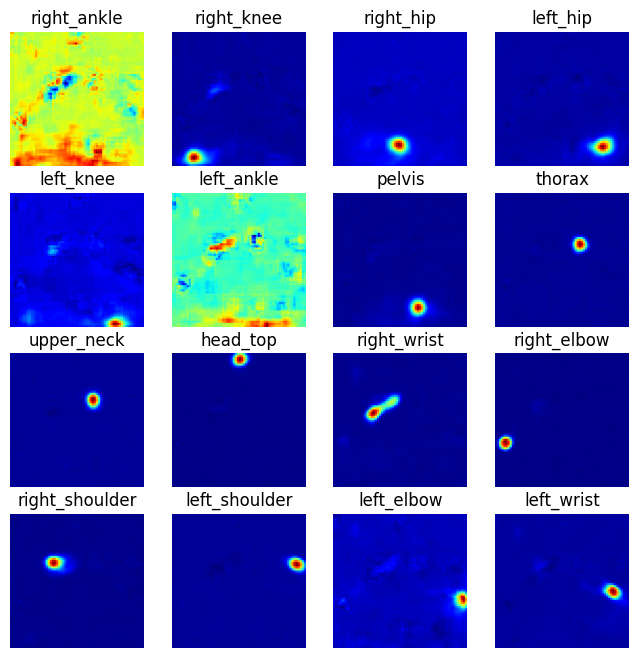

In [129]:
plot_grids(
    heatmap,
    titles=MPII_CLASS_NAMES,
    num_row=4,
    num_col=4,
    # is_gray_scale=True,
    cmap="jet",
)

In [130]:
keypoints = np.column_stack(
    np.unravel_index(
        heatmap.reshape(16, -1).argmax(-1),
        heatmap.shape[1:],
    )
)

In [131]:
keypoints

array([[228, 164],
       [236,  40],
       [212, 124],
       [216, 204],
       [248, 200],
       [252, 180],
       [216, 160],
       [ 96, 160],
       [ 88, 156],
       [ 12, 128],
       [112,  76],
       [168,  20],
       [ 92,  80],
       [ 96, 236],
       [160, 248],
       [144, 224]])

In [132]:
from torchlake.common.utils.image import overlay_image
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.pose_estimation.utils.plot import draw_skeleton

In [133]:
copy_img = img_tensor_to_np(x)
draw_skeleton(
    copy_img,
    # keypoints[None, ...],
    np.flip(keypoints[None, ...], axis=-1),
    class_names=MPII_CLASS_NAMES,
    class_edges=MPII_JOINT_EDGES,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


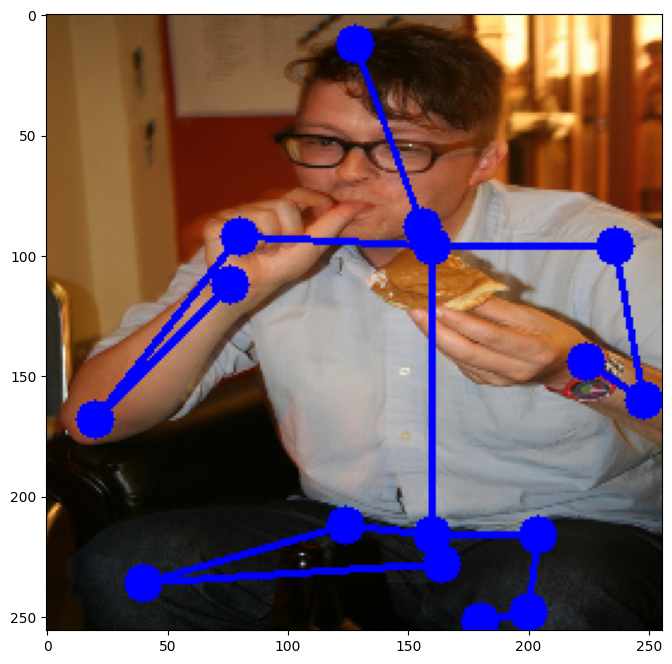

In [134]:
plt.figure(figsize=(8,8))
plt.imshow(copy_img)

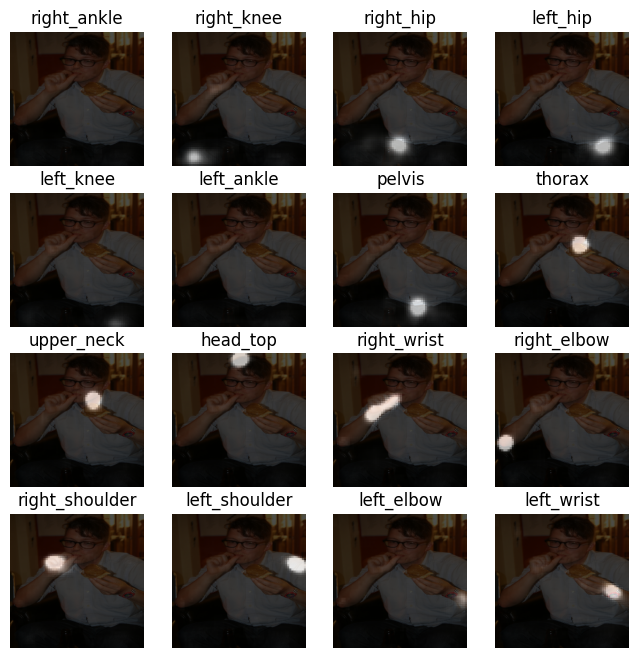

In [135]:
plot_grids(
    [
        overlay_image(img_tensor_to_np(x), np.repeat(hm[:,:, None], 3, axis=-1).clip(0, 1), 0.7) 
        for hm in heatmap
    ],
    titles=MPII_CLASS_NAMES,
    num_row=4,
    num_col=4,
    cmap="jet",
)

# evaluation

## train accuracy

In [26]:
# larger batch size won't make it faster, already hits the transport limit
VAL_BATCH_SIZE = 32

In [27]:
val_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(
        format="xy",
        remove_invisible=False,
    ),
)

In [28]:
val_dataset = MPIIFromLMDB(
    "F://data/MPII",
    transform=val_transform,
)

In [29]:
val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    # num_workers=get_num_workers(),
    pin_memory=True,
    # for raw, json version uncomment the following line
    # lmdb doesn't need
    # collate_fn=collate_fn if train_dataset.crop_by_person else None, 
)

In [30]:
from torchlake.pose_estimation.controller.hourglass.evaluator import PoseEstimationEvaluator
from torchlake.pose_estimation.metrics import PCK

In [31]:
evaluator = PoseEstimationEvaluator(NUM_CLASS, DEVICE)

In [52]:
metric = PCK(
    NUM_CLASS,
    threshold_type="head",
    threshold=0.5,
    head_top_index=MPII_CLASS_NAMES.index("head_top"),
    neck_index=MPII_CLASS_NAMES.index("upper_neck"),
    left_shoulder_index=MPII_CLASS_NAMES.index("left_shoulder"),
    right_hip_index=MPII_CLASS_NAMES.index("right_hip"),
    visible_only=True,
)

In [53]:
evaluator.run(val_loader, model, metric)

100%|██████████| 893/893 [05:32<00:00,  2.69it/s]

In [54]:
metric.show_per_class_accuracy(MPII_CLASS_NAMES)

# for class_name, acc in zip(MPII_CLASS_NAMES, metric.hits):
#     print(f"{class_name}: {(acc[0] / acc[1]).item():.2f}")

right_ankle: 0.05
right_knee: 0.09
right_hip : 0.14
left_hip  : 0.22
left_knee : 0.19
left_ankle: 0.10
pelvis    : 0.31
thorax    : 0.18
upper_neck: 0.00
head_top  : 0.07
right_wrist: 0.11
right_elbow: 0.12
right_shoulder: 0.27
left_shoulder: 0.09
left_elbow: 0.13
left_wrist: 0.15


In [55]:
print(f"{metric.get_total_accuracy():.4f}")

0.1390


In [56]:
metric.hits.long()

tensor([[  827, 15338],
        [ 1768, 19044],
        [ 2822, 20393],
        [ 4544, 20444],
        [ 3615, 19061],
        [ 1467, 15344],
        [ 4862, 15634],
        [ 2915, 16328],
        [    0,     2],
        [ 2000, 28356],
        [ 2379, 21495],
        [ 2674, 22282],
        [ 6141, 22409],
        [ 1923, 22078],
        [ 2915, 21881],
        [ 3079, 21036]])